In [79]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt

In [2]:
data_graffiti = pd.read_csv('graffiti.csv')
data_pot_holes = pd.read_csv('pot_holes.csv')
data_sanitation = pd.read_csv('sanitation.csv')
data_vacant = pd.read_csv('vacant.csv')


In [3]:
graff = {"creation_date": list(data_graffiti["Creation Date"]),
         "completion_time": list(data_graffiti["Completion Date"]),
         "latitude": data_graffiti["Latitude"],
         "longitude": data_graffiti["Longitude"],
         "request_type": list(data_graffiti["Type of Service Request"])}

In [4]:
vacant = {"creation_date": list(data_vacant["DATE SERVICE REQUEST WAS RECEIVED"]),
         "completion_time": [float("NaN")]*data_vacant.shape[0],
         "latitude": data_vacant["LATITUDE"],
         "longitude": data_vacant["LONGITUDE"],
         "request_type": list(data_vacant["SERVICE REQUEST TYPE"])}

In [5]:
pot_holes = {"creation_date": list(data_pot_holes["CREATION DATE"]),
         "completion_time": list(data_pot_holes["COMPLETION DATE"]),
         "latitude": data_pot_holes["LATITUDE"],
         "longitude": data_pot_holes["LONGITUDE"],
         "request_type": list(data_pot_holes["TYPE OF SERVICE REQUEST"])}

In [6]:
sanitation = {"creation_date": list(data_sanitation["Creation Date"]),
         "completion_time": list(data_sanitation["Completion Date"]),
         "latitude": data_sanitation["Latitude"],
         "longitude": data_sanitation["Longitude"],
         "request_type": list(data_sanitation["Type of Service Request"])}

In [7]:
df_graff = pd.DataFrame(graff)
df_vacant = pd.DataFrame(vacant)
df_pot_holes = pd.DataFrame(pot_holes)
df_sanitation = pd.DataFrame(sanitation)


In [92]:
complete = pd.concat([df_graff, df_vacant, df_pot_holes, df_sanitation], axis=0)

In [98]:
# Compute total counts by request time and creation_date
counts = complete.groupby( [ "creation_date", "request_type"] )
counts = counts.size().to_frame().reset_index()
counts = counts.rename(columns={0 : "total"})
counts = counts.sort_values(by = "creation_date")
#counts["creation_date"] = pd.to_datetime(counts["creation_date"] )

In [51]:
def filter_func(df,type):
    if type == "graffiti":
        I = df['request_type'].str.contains("Graffiti Removal")
    elif type == "vacant":
        I = df['request_type'].str.contains("Vacant/Abandoned Building")
    elif type == "potholes":
        I = df['request_type'].str.contains("Pothole in Street")
    else:
        I = df['request_type'].str.contains("Sanitation Code Violation")
    return df[I]

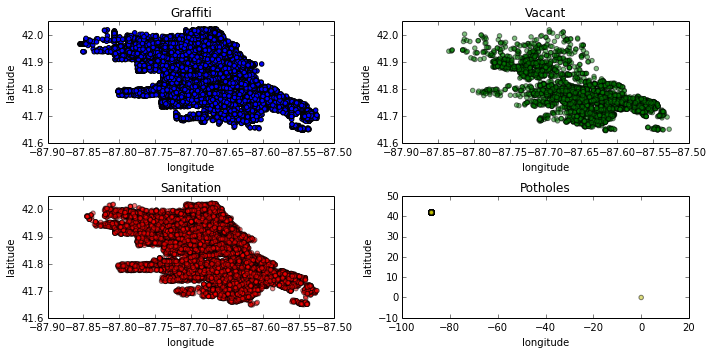

In [52]:
# Location of total requests by request type
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
filter_func(complete, "graffiti").plot(kind='scatter', x='longitude', y='latitude', ax=axes[0,0]); axes[0,0].set_title('Graffiti')
filter_func(complete, "vacant").plot(kind='scatter', x='longitude', y='latitude', alpha = 0.5, color ="g", ax=axes[0,1]); axes[0,1].set_title('Vacant')
filter_func(complete, "sanitation").plot(kind='scatter', x='longitude', y='latitude', alpha = 0.5, color="r", ax=axes[1,0]); axes[1,0].set_title('Sanitation')
filter_func(complete, "potholes").plot(kind='scatter', x='longitude', y='latitude', alpha = 0.5, color="y", ax=axes[1,1]); axes[1,1].set_title('Potholes')
fig.tight_layout()



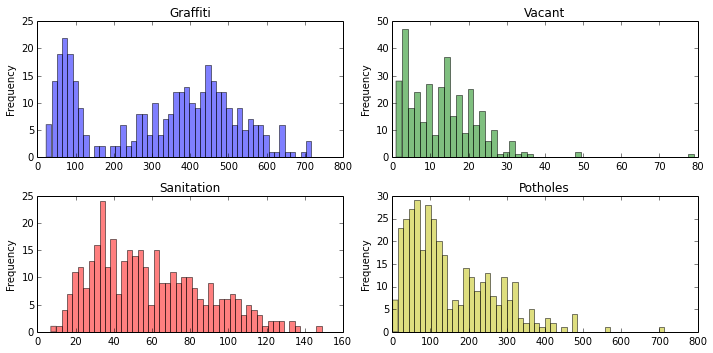

In [99]:
# Distribution of requestes during March 2016 to March 2017

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

filter_func(counts, "graffiti")["total"].plot('hist', bins=50, alpha = 0.5, ax=axes[0,0]); axes[0,0].set_title('Graffiti')
filter_func(counts, "vacant")["total"].plot('hist', bins=50, alpha = 0.5, ax=axes[0,1], color ="g"); axes[0,1].set_title('Vacant')
filter_func(counts, "sanitation")["total"].plot('hist', bins=50, alpha = 0.5, ax=axes[1,0], color="r"); axes[1,0].set_title('Sanitation')
filter_func(counts, "potholes")["total"].plot('hist', bins=50, alpha = 0.5, ax=axes[1,1], color="y"); axes[1,1].set_title('Potholes')
fig.tight_layout()

In [85]:
# Summary of Graffiti Requests during March 2016- March 2017
filter_func(counts, "graffiti").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total,364.0,321.527473,186.849011,23.0,102.75,363.5,466.0,717.0


In [86]:
# Summary of Vacant/ Building Requests during March 2016- March 2017
filter_func(counts, "vacant").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total,361.0,13.174515,9.173937,1.0,5.0,13.0,19.0,79.0


In [87]:
#  Summary of Sanitation Requests during March 2016- March 2017
filter_func(counts, "sanitation").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total,364.0,58.912088,29.046329,7.0,35.0,54.0,78.0,149.0


In [84]:
# Summary of Potholes Requests during March 2016- March 2017
filter_func(counts, "potholes").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total,365.0,152.315068,114.737766,1.0,63.0,116.0,229.0,713.0


In [108]:
# Function from Stackeoverflow to make datetime function faster
def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [150]:
def response_time(df, type):
    """
    Given a dataframe, computes the difference between creation date
    and completion time for the request. It adds an extra column with
    the difference to the dataframe in hours
    Input: dataframe and request tyoe (string)
    Returns: Modified dataframe
    """
    df_g = filter_func(complete, type).sort_values(by = "creation_date")
    df_g["creation_date"] = lookup(df_g["creation_date"] )
    df_g["completion_time"] = lookup(df_g["completion_time"] )
    df_g['difference'] = df_g['creation_date'].sub(df_g['completion_time'], axis=0)
    df_g['difference'] = df_g['difference'] / np.timedelta64(1, 'D')*-1
    del df_g["latitude"]
    del df_g["longitude"]
    return df_g

In [151]:
response_time(complete, "graffiti").describe().transpose()


,count,mean,std,min,25%,50%,75%,max
difference,116882.0,0.667904,1.021351,-0.0,-0.0,-0.0,1.0,25.0


In [152]:
response_time(complete, "potholes").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
difference,52631.0,23.662784,35.590511,-0.0,2.0,8.0,30.0,321.0


In [153]:
response_time(complete, "sanitation").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
difference,21202.0,8.881851,13.951351,-0.0,2.0,4.0,11.0,183.0


3. Based on	these summary statistics, tell me 5 interesting things you	learned	using the 311 data.
   i) According to the maps, Graffiti and Sanitation reports are ubiquitous in the city of Chicago, while pothole        requests seemed to be very focalized to certain neighborhoods.
   ii) The distribution of Graffiti requests seems to be bimodal. The first mode is between 50-60 requests and 
       the second one is around 250. Additionally, the average number of graffiti requests is huge!! 321.5.
   iii) From the four types of requests, vacant and abandoned buildings was the one with the fewest average requests,
         13.17, during 2016-2017.
   iv) 